In [13]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.utils import timeseries_dataset_from_array
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import SimpleRNN
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv("jena_climate_2009_2016.csv")

In [4]:
temperature = df["T (degC)"].values

In [5]:
raw_data = df.loc[:, "p (mbar)":"wd (deg)"].values

**Data split**

In [6]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples

**Normalizing the data**

In [7]:
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean

std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

**Instantiating datasets for training, validation, and testing**

In [8]:
sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

In [9]:
train_dataset = timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

**An RNN layer that can process sequences of any length**

In [19]:
num_features = 14
inputs = Input(shape=(None, num_features))
outputs = SimpleRNN(16)(inputs)
model = Model(inputs, outputs)
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset, epochs=10, validation_data=val_dataset)

Epoch 1/10
819/819 [==============================] - 53s 63ms/step - loss: 139.1582 - mae: 9.7176 - val_loss: 144.2467 - val_mae: 9.9276
Epoch 2/10
819/819 [==============================] - 52s 64ms/step - loss: 136.4020 - mae: 9.5621 - val_loss: 143.7609 - val_mae: 9.8748
Epoch 3/10
819/819 [==============================] - 51s 62ms/step - loss: 136.2431 - mae: 9.5495 - val_loss: 143.7359 - val_mae: 9.8776
Epoch 4/10
819/819 [==============================] - 51s 62ms/step - loss: 136.2158 - mae: 9.5468 - val_loss: 143.6772 - val_mae: 9.8697
Epoch 5/10
819/819 [==============================] - 51s 62ms/step - loss: 136.1543 - mae: 9.5397 - val_loss: 143.6290 - val_mae: 9.8628
Epoch 6/10
819/819 [==============================] - 54s 66ms/step - loss: 136.1160 - mae: 9.5357 - val_loss: 143.5817 - val_mae: 9.8556
Epoch 7/10
819/819 [==============================] - 54s 66ms/step - loss: 136.0927 - mae: 9.5341 - val_loss: 143.6300 - val_mae: 9.8637
Epoch 8/10
819/819 [==============

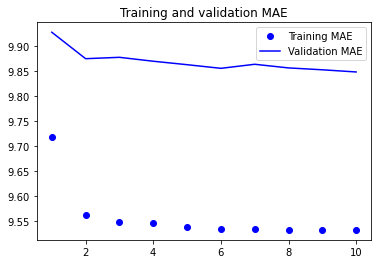

In [20]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

**An RNN layer that returns only its last output step**

In [21]:
num_features = 14
steps = 120
inputs = Input(shape=(steps, num_features))
outputs = SimpleRNN(16, return_sequences=False)(inputs)
model = Model(inputs, outputs)
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history1 = model.fit(train_dataset, epochs=10, validation_data=val_dataset)

Epoch 1/10
819/819 [==============================] - 56s 68ms/step - loss: 138.7260 - mae: 9.6865 - val_loss: 144.1446 - val_mae: 9.9151
Epoch 2/10
819/819 [==============================] - 56s 68ms/step - loss: 136.4657 - mae: 9.5683 - val_loss: 143.7686 - val_mae: 9.8754
Epoch 3/10
819/819 [==============================] - 56s 68ms/step - loss: 136.2767 - mae: 9.5515 - val_loss: 143.7369 - val_mae: 9.8696
Epoch 4/10
819/819 [==============================] - 55s 67ms/step - loss: 136.1825 - mae: 9.5438 - val_loss: 143.5929 - val_mae: 9.8585
Epoch 5/10
819/819 [==============================] - 54s 65ms/step - loss: 136.1838 - mae: 9.5418 - val_loss: 143.5914 - val_mae: 9.8553
Epoch 6/10
819/819 [==============================] - 55s 67ms/step - loss: 136.1385 - mae: 9.5357 - val_loss: 143.5407 - val_mae: 9.8503
Epoch 7/10
819/819 [==============================] - 53s 65ms/step - loss: 136.1144 - mae: 9.5333 - val_loss: 143.4966 - val_mae: 9.8457
Epoch 8/10
819/819 [==============

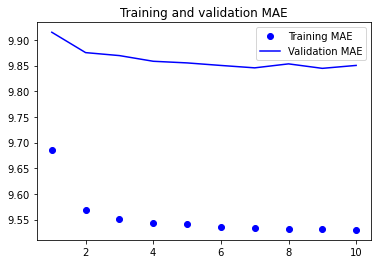

In [22]:
loss = history1.history["mae"]
val_loss = history1.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

**An RNN layer that returns its full output sequence**

In [23]:
num_features = 14
steps = 120
inputs = Input(shape=(steps, num_features))
outputs = SimpleRNN(16, return_sequences=True)(inputs)
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history2 = model.fit(train_dataset, epochs=10, validation_data=val_dataset)

Epoch 1/10
819/819 [==============================] - 55s 66ms/step - loss: 136.0872 - mae: 9.5302 - val_loss: 143.4914 - val_mae: 9.8453
Epoch 2/10
819/819 [==============================] - 54s 66ms/step - loss: 136.0821 - mae: 9.5297 - val_loss: 143.5178 - val_mae: 9.8487
Epoch 3/10
819/819 [==============================] - 54s 66ms/step - loss: 136.0704 - mae: 9.5285 - val_loss: 143.4999 - val_mae: 9.8461
Epoch 4/10
819/819 [==============================] - 55s 68ms/step - loss: 136.0605 - mae: 9.5273 - val_loss: 143.5295 - val_mae: 9.8512
Epoch 5/10
819/819 [==============================] - 55s 67ms/step - loss: 136.0535 - mae: 9.5265 - val_loss: 143.4802 - val_mae: 9.8447
Epoch 6/10
819/819 [==============================] - 55s 67ms/step - loss: 136.0733 - mae: 9.5281 - val_loss: 143.5459 - val_mae: 9.8530
Epoch 7/10
819/819 [==============================] - 55s 67ms/step - loss: 136.0510 - mae: 9.5259 - val_loss: 143.4648 - val_mae: 9.8426
Epoch 8/10
819/819 [==============

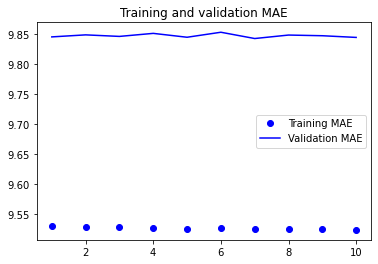

In [24]:
loss = history2.history["mae"]
val_loss = history2.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

**Stacking RNN layers**

In [27]:
inputs = Input(shape=(steps, num_features))
x = SimpleRNN(16, return_sequences=True)(inputs)
x = SimpleRNN(16, return_sequences=True)(x)
outputs = SimpleRNN(16)(x)
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history3 = model.fit(train_dataset, epochs=10, validation_data=val_dataset)

Epoch 1/10
819/819 [==============================] - 60s 72ms/step - loss: 136.0225 - mae: 9.5217 - val_loss: 143.5047 - val_mae: 9.8486
Epoch 2/10
819/819 [==============================] - 60s 73ms/step - loss: 136.0551 - mae: 9.5260 - val_loss: 143.4656 - val_mae: 9.8432
Epoch 3/10
819/819 [==============================] - 58s 71ms/step - loss: 136.0476 - mae: 9.5249 - val_loss: 143.4385 - val_mae: 9.8403
Epoch 4/10
819/819 [==============================] - 57s 70ms/step - loss: 136.0352 - mae: 9.5236 - val_loss: 143.4861 - val_mae: 9.8452
Epoch 5/10
819/819 [==============================] - 57s 70ms/step - loss: 136.0194 - mae: 9.5220 - val_loss: 143.4879 - val_mae: 9.8453
Epoch 6/10
819/819 [==============================] - 60s 73ms/step - loss: 136.0140 - mae: 9.5213 - val_loss: 143.4549 - val_mae: 9.8402
Epoch 7/10
819/819 [==============================] - 59s 72ms/step - loss: 136.0101 - mae: 9.5207 - val_loss: 143.4664 - val_mae: 9.8422
Epoch 8/10
819/819 [==============

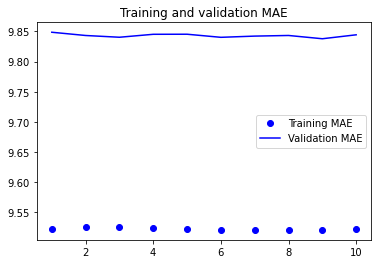

In [29]:
loss = history3.history["mae"]
val_loss = history3.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()